In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
from torch import nn
from simulators import SimulatorBlob
import scipy.ndimage
import numpy as np
from PIL import Image, ImageFont, ImageDraw
#import RatioEstimatorCube
from unet import UNet
import scipy.ndimage as ndimage

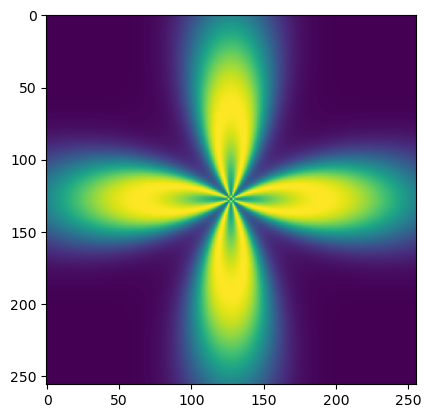

In [35]:
class SimulatorRing(swyft.Simulator):
    def __init__(self, sigma = 2.0):
        super().__init__()
        self.sigma = sigma
        self.transform_samples = swyft.to_numpy32
        
    def get_prob_dist1(self, sigmaR, R0):
        l = np.linspace(-10, 10, 256)
        X, Y = np.meshgrid(l, l)
        R = (X**2 + Y**2)**0.5
        P = np.exp(-0.5*(R-R0)**2/sigmaR**2)
        P /= P.sum()
        return P
    
    def get_prob_dist2(self, sigmaR, R0):
        l = np.linspace(-10, 10, 256)
        X, Y = np.meshgrid(l, l)
        phi = np.arctan2(X, Y)
        R = (X**2 + Y**2)**0.5
        P = np.exp(-0.5*(R-R0*np.cos(phi*4))**2/sigmaR**2)
        P /= P.sum()
        return P
    
    def gen_pos(self):
        x, y = np.random.rand(2)*256-128
        y += 75
        return np.array([x, y])
    
    def build(self, graph):
        pos = graph.node("pos", self.gen_pos)
        mu = graph.node('mu', self.gen_image, pos)
        x = graph.node('x', lambda mu: mu + np.random.randn(*mu.shape)*self.sigma, mu)
        
sim = SimulatorRing()
p = sim.get_prob_dist2(4, 5)
plt.imshow(p)

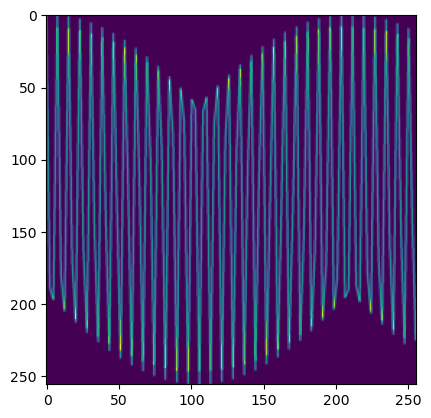

In [80]:
import cv2, numpy, scipy.ndimage, skimage
for i in range(100):
    x_values = np.linspace(0, 1024, 100)
    y_values = np.sin(x_values/10)**2*1024
    # You can do the same on OpenCV like this
    image = np.zeros((1024, 1024))
    curve = numpy.column_stack((x_values.astype(numpy.int32), y_values.astype(numpy.int32)))
    cv2.polylines(image, [curve], False, (1,255,255))
    image = scipy.ndimage.gaussian_filter(image, 1)
    image = skimage.transform.resize(image, (256, 256))
plt.imshow(image)

In [131]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_Gaussian(256*256, varnames = 'mu')
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3)
        self.unet = UNet(1, 1, s = 4)
        
    def forward(self, A, B):
        mu = A['x']
        f = self.unet(mu.unsqueeze(1)).squeeze(1)
        f = f.flatten(start_dim = 1)
        z = B['mu'].flatten(start_dim = 1)
        logratios = self.logratios(f.unsqueeze(-1), z.unsqueeze(-1))
        return logratios
    
net = Network()

In [132]:
sim = SimulatorUnraveling(sigma = 1.0)
#samples = sim.sample(8192)
dl = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0], batch_size = 128)

In [136]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 20, precision = 32)
trainer.fit(net, dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                       | Params
---------------------------------------------------------
0 | logratios | LogRatioEstimator_Gaussian | 0     
1 | unet      | UNet                       | 1.9 M 
---------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

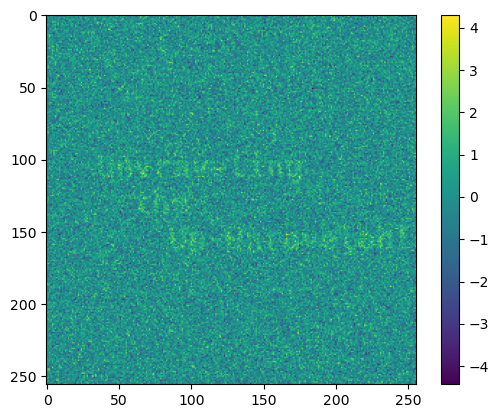

In [139]:
sample0 = samples[6]
plt.imshow(sample0['x'])
plt.colorbar()

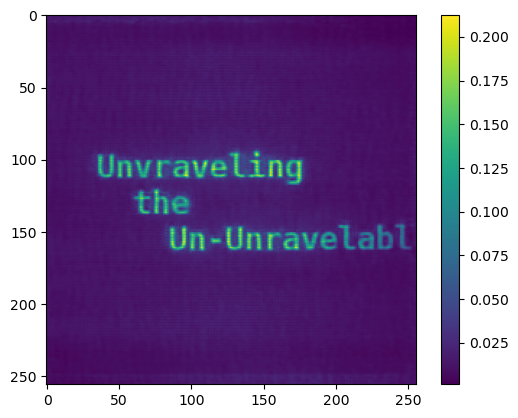

In [143]:
def get_MAP(self, x):
    rho = self.cov[:,0,1]/self.cov[:,0,0]**0.5/self.cov[:,1,1]**0.5
    return (x-self.mean[:,0])*rho*self.cov[:,1,1]**0.5 + self.mean[:,1]
    
net.cuda()
x = torch.tensor(sample0['x']).cuda()
x = x.unsqueeze(0).unsqueeze(0)
f = net.unet(x).squeeze(1).flatten(start_dim = 1).detach()
x = get_MAP(net.logratios, f).reshape(256, 256)
plt.imshow(x.detach().cpu())
plt.colorbar()